In [1]:
import pandas as pd
import numpy as np

In [9]:
import sys
sys.path.insert(0, '/workspaces/eda')  # Replace 'path/to/parent_directory' with the absolute path to the parent directory
print(sys.path)  # Add this line to check sys.path

['/workspaces/eda', '/workspaces/', '/workspaces/dca_ml_models/eda/', '/workspaces/dca_ml_models/models_experimentation', '/home/codespace/.python/current/lib/python310.zip', '/home/codespace/.python/current/lib/python3.10', '/home/codespace/.python/current/lib/python3.10/lib-dynload', '', '/home/codespace/.local/lib/python3.10/site-packages', '/home/codespace/.python/current/lib/python3.10/site-packages']


In [12]:
import eda

ModuleNotFoundError: No module named 'eda'

In [10]:
import os
os.getcwd()

'/workspaces/dca_ml_models/models_experimentation'

In [11]:
from eda import exp

ModuleNotFoundError: No module named 'eda'

In [8]:
df = exp.import_data()
df_pdoil = df[['DATE', 'PD_Oil Rate (stb/day)']]


# Rename columns to generic names
df_pdoil = df_pdoil.rename(columns={'DATE': 'ds', 'PD_Oil Rate (stb/day)': "y"})

df_pdoil_clean = df_pdoil.dropna(axis=0)

# Split data frame to train and test
X_train, y_train, X_test, y_test = exp.train_test_split_by_date(df_pdoil_clean, 'ds', 'y', '1999-01-01')

df_train = pd.concat([X_train, y_train], axis=1)
df_test =pd.concat([X_test, y_test], axis=1)

In [9]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [25]:
import matplotlib.pyplot as plt


def create_windows(train_data, window_size=3):
    X, y = [], []
    for i in range(len(train_data) - window_size):
        window = train_data[i:(i + window_size)]
        X.append(window)
        y.append(train_data[i + window_size])
    return np.array(X), np.array(y)


def plot_forecast(y_test, y_forecast, ds, title=''):
    # Plotting actual vs predicted values
    plt.figure(figsize=(14, 5))
    plt.plot(ds, y_test, label='Actual', color='b', marker='o')
    plt.plot(ds, y_forecast, label=title, color='r', marker='d')
    # Use xgb_forecast for XGBoost or any other forecast
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.show()
    
    
# import matplotlib.pyplot as plt

# def plot_forecast(y_test, y_forecast):
#     # Plotting actual vs predicted values
#     plt.figure(figsize=(8, 6))
#     plt.plot(y_test, label='Actual', marker='o')
#     plt.plot(y_forecast, label='Random Forest Forecast', marker='x')
#     # Use xgb_forecast for XGBoost or any other forecast
#     plt.xlabel('Index')
#     plt.ylabel('Value')
#     plt.title('Actual vs Predicted Values')
#     plt.legend()
#     plt.show()

In [36]:


# Splitting train data into input windows and output
X_train_windows, y_train_windows = create_windows(y_train.values)
X_test_windows, y_test_windows = create_windows(y_test.values)

# Perform splits on the date columns as well
_, ds_train_windows = create_windows(X_train.values)
_, ds_test_windows = create_windows(X_test.values)

In [12]:
y_train_windows.shape, ds_train_windows.flatten().shape

((244,), (244,))

In [48]:
# Initialize Random Forest and XGBoost models
rf_model = RandomForestRegressor(
    n_estimators = 100
)

# Fit Random Forest and XGBoost models on the input windows and output
rf_model.fit(X_train_windows, y_train_windows)

rf_forecast = rf_model.predict(X_train_windows)
rf_mape = mean_absolute_percentage_error(y_train_windows, rf_forecast)
rf_mae = mean_absolute_error(y_train_windows, rf_forecast)
rf_mse = mean_squared_error(y_train_windows, rf_forecast)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_train_windows, rf_forecast)

print("Random Forest MAPE:", rf_mape)
print("Random Forest MAE:", rf_mae)
print("Random Forest MSE:", rf_mse)
print("Random Forest RMSE:", rf_rmse)
print("Random Forest R2:", rf_r2)

Random Forest MAPE: 0.05132613270523015
Random Forest MAE: 98.91626103803374
Random Forest MSE: 39953.6218618229
Random Forest RMSE: 199.88402102675167
Random Forest R2: 0.9336628432888541


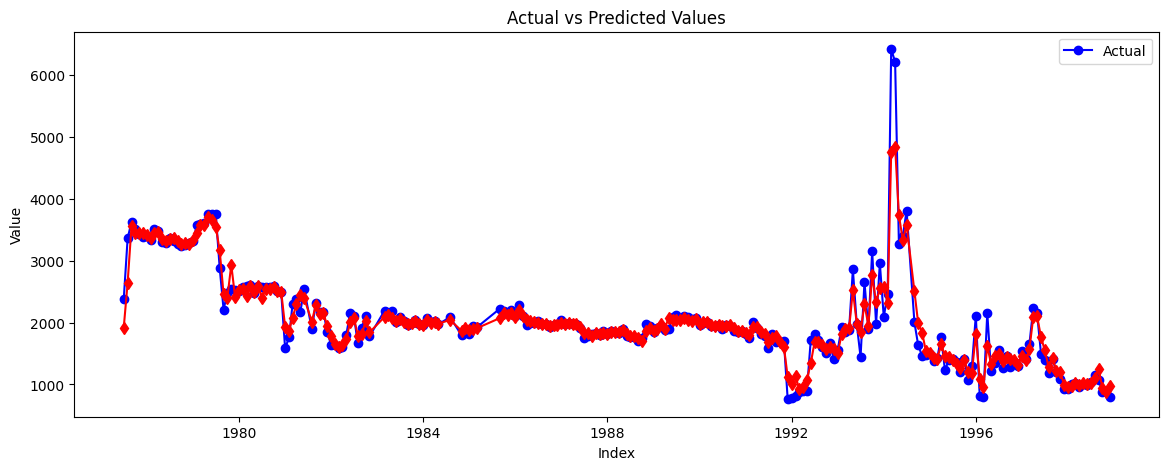

In [49]:
rf_train_forecast = rf_model.predict(X_train_windows)
plot_forecast(y_train_windows, rf_train_forecast, ds_train_windows.flatten())

In [50]:
# Initialize a list to store forecasted values
forecast = []

# Initialize the initial window for the XGBoost model
window = X_test_windows[-1].reshape(1, -1)  # Assuming window_size is defined

# Generate future timestamps for forecasting
PERIODS=24
latest_timestamp = X_test['ds'].iloc[-1]
future_timestamps = pd.date_range(start=latest_timestamp, periods=PERIODS, freq='M')  # Your desired future timestamps

# Iterate through future timestamps
for timestamp in future_timestamps:
    # Use the current window to predict the next value
    prediction = rf_model.predict(window)  # Reshape the window as needed
    
    # Append the prediction to the forecast
    forecast.append(prediction[0])
    
    # Update the window by removing the oldest value and adding the latest prediction
    window = np.append(window.flatten()[1:], prediction).reshape(1, -1)

# Create a DataFrame with the forecasted values and their corresponding timestamps
forecast_df = pd.DataFrame({'ds': future_timestamps, 'yhat': forecast})

future_forcast = forecast_df['yhat']
future_ds = forecast_df['ds']

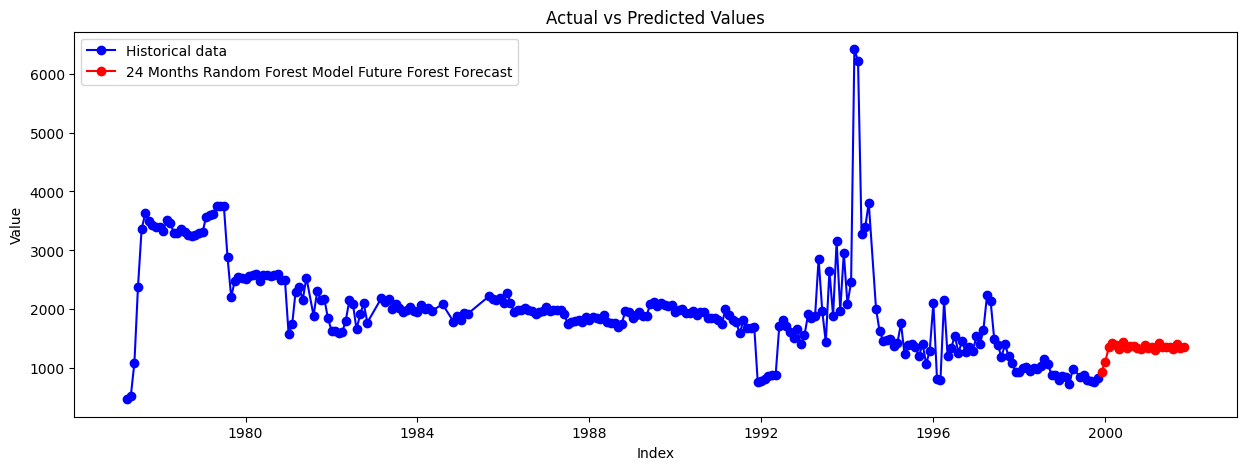

In [52]:
import matplotlib.pyplot as plt

#def plot_forecast(y_test, y_forecast, ds):
    # Plotting actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(df_pdoil_clean['ds'], df_pdoil_clean['y'], color='b', label='Historical data', marker='o')
#plt.plot(ds_train_windows.flatten(), xgb_train_forecast, color='r', label='Random Forest Forecast', marker='x')
plt.plot(future_ds, future_forcast, color='r', label=f'{PERIODS} Months Random Forest Model Future Forest Forecast', marker='o')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
#plt.grid(True)
#plt.tight_layout()
plt.show()

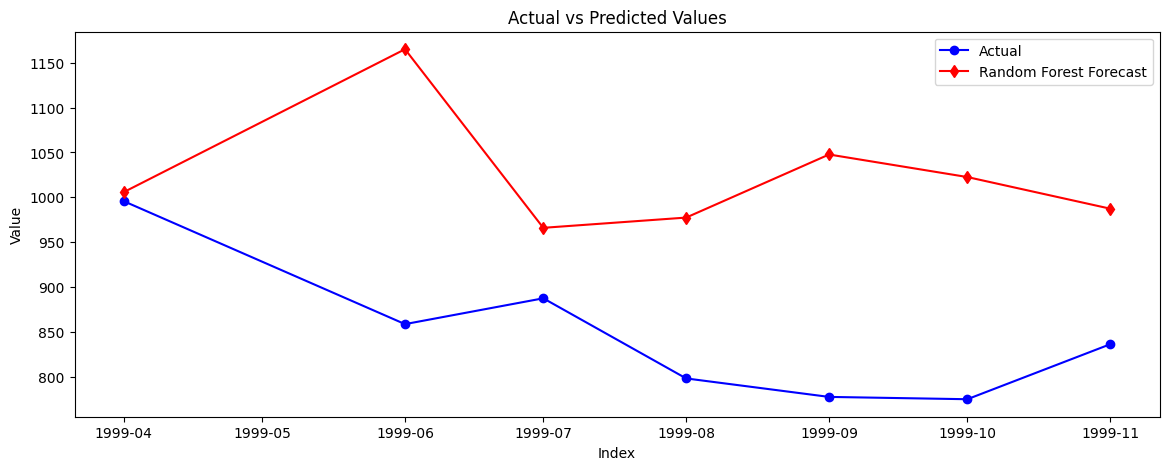

In [11]:
plot_forecast(y_test_windows, rf_forecast, ds_test_windows.flatten())

## XGBOOST MODEL

In [14]:

xgb_model = XGBRegressor()

xgb_model.fit(X_train_windows, y_train_windows)

xgb_forecast = xgb_model.predict(X_test_windows)
xgb_mape = mean_absolute_percentage_error(y_test_windows, xgb_forecast)
print("XGBoost MAPE:", xgb_mape)


XGBoost MAPE: 0.16404454799279208


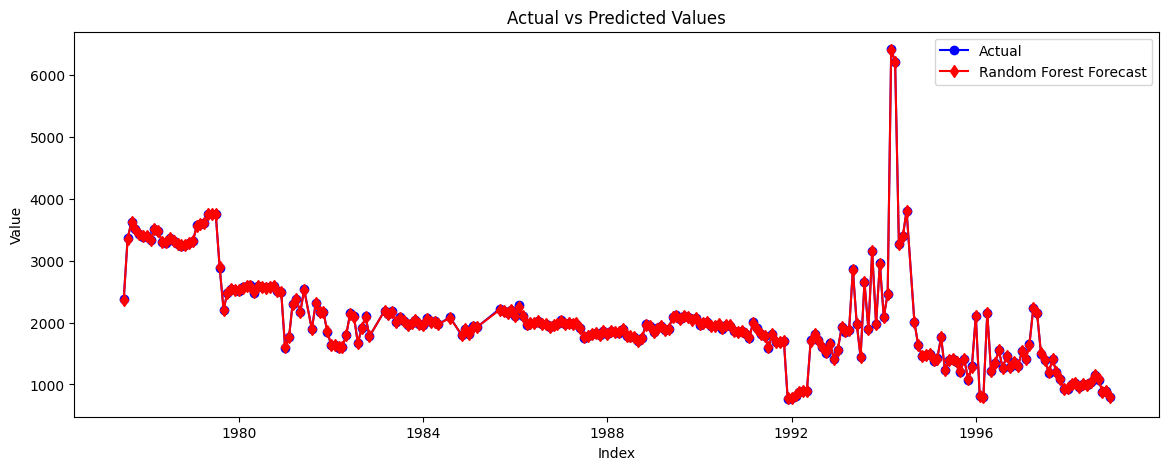

In [15]:
xgb_train_forecast = xgb_model.predict(X_train_windows)
plot_forecast(y_train_windows, xgb_train_forecast, ds_train_windows.flatten())

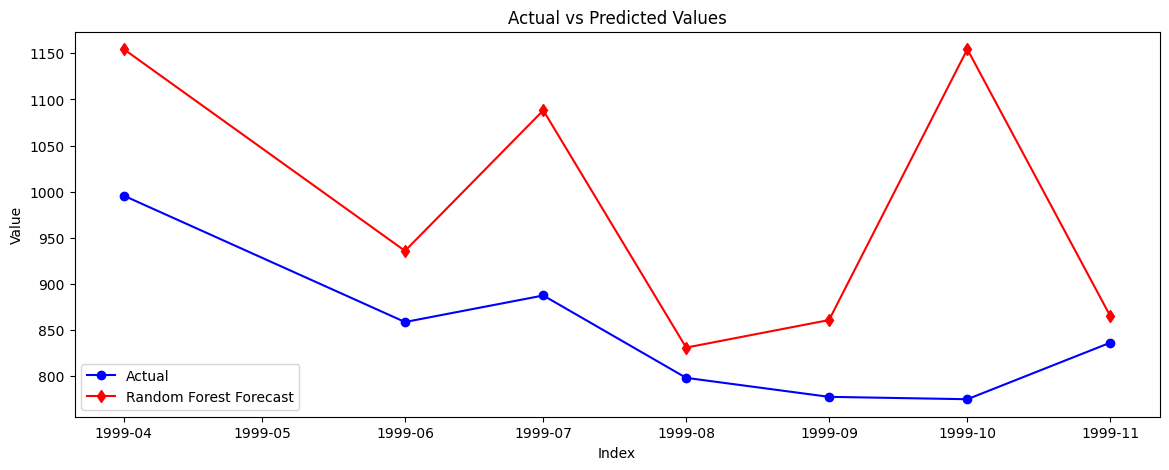

In [16]:
plot_forecast(y_test_windows, xgb_forecast, ds_test_windows.flatten())

In [17]:
y_test.shape, y_test_windows.shape

((10,), (7,))

In [18]:
xgb_test_forecast = xgb_model.predict(X_test_windows)

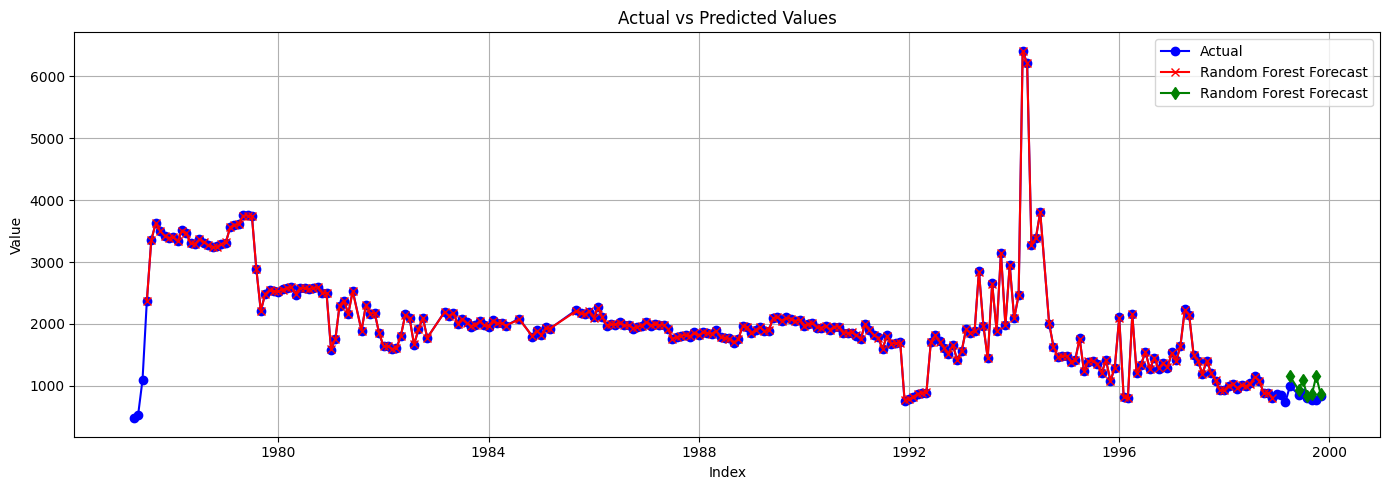

In [19]:
import matplotlib.pyplot as plt

#def plot_forecast(y_test, y_forecast, ds):
    # Plotting actual vs predicted values
plt.figure(figsize=(14, 5))
plt.plot(df_pdoil_clean['ds'], df_pdoil_clean['y'], color='b', label='Actual', marker='o')
plt.plot(ds_train_windows.flatten(), xgb_train_forecast, color='r', label='Random Forest Forecast', marker='x')
plt.plot(ds_test_windows.flatten(), xgb_test_forecast, color='g', label='Random Forest Forecast', marker='d')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Hyperparameter search with xgboost

In [32]:
from sklearn.model_selection import ParameterGrid
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd

# Define the parameter grid for XGBoost
xgb_params_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    #'subsample': [0.8, 0.9, 1.0],
    #'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_grid = ParameterGrid(xgb_params_grid)
cnt = 0
for p in xgb_grid:
    cnt += 1

print('Total Possible Models for XGBoost:', cnt)

xgb_model_parameters = pd.DataFrame(columns=['MAPE', 'Parameters'])  # Ensure it's explicitly a DataFrame

# Your loop for XGBoost hyperparameter search
for p in xgb_grid:
    xgb_model = XGBRegressor(
        n_estimators=p['n_estimators'],
        max_depth=p['max_depth'],
        learning_rate=p['learning_rate'],

    )
    
    xgb_model.fit(X_train_windows, y_train_windows)
    xgb_forecast = xgb_model.predict(X_test_windows)
    
    xgb_mape = mean_absolute_percentage_error(y_test_windows, xgb_forecast)
    
    xgb_model_parameters = pd.concat([xgb_model_parameters, pd.DataFrame({'MAPE': [xgb_mape], 'Parameters': [p]})], ignore_index=True)


Total Possible Models for XGBoost: 27


/tmp/ipykernel_2214/2713081287.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  xgb_model_parameters = pd.concat([xgb_model_parameters, pd.DataFrame({'MAPE': [xgb_mape], 'Parameters': [p]})], ignore_index=True)


In [33]:
parameters = xgb_model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,0.129170,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
1,0.129222,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
2,0.130690,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti..."
3,0.133776,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."
4,0.135226,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."


In [193]:
xgb_forecast.shape

(7,)

In [23]:

xgb_model_best = XGBRegressor(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=300
)

xgb_model_best.fit(X_train_windows, y_train_windows)

xgb_forecast = xgb_model_best.predict(X_train_windows)
xgb_mape = mean_absolute_percentage_error(y_train_windows, xgb_forecast)
xgb_mae = mean_absolute_error(y_train_windows, xgb_forecast)
xgb_mse = mean_squared_error(y_train_windows, xgb_forecast)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_train_windows, xgb_forecast)

print("XGBoost MAPE:", xgb_mape)
print("XGBoost MAE:", xgb_mae)
print("XGBoost MSE:", xgb_mse)
print("XGBoost RMSE:", xgb_rmse)
print("XGBoost R2:", xgb_r2)

XGBoost MAPE: 2.6323502412933178e-05
XGBoost MAE: 0.04723521991890719
XGBoost MSE: 0.0045300959138217176
XGBoost RMSE: 0.06730598720635274
XGBoost R2: 0.9999999924784371


In [21]:
df_traintest = pd.concat((df_train, df_test)) # combined for full training


In [22]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # Define the number of splits or folds
list(tscv.split(y_combined_windows))[0]

NameError: name 'y_combined_windows' is not defined

In [201]:
train_index, test_index = y_combined_windows

array([2372.23300971, 3357.98701299, 3628.86666667, 3506.60899654,
       3423.6196319 , 3389.27835052, 3400.        , 3334.65437788,
       3514.06451613, 3473.43333333, 3300.93851133, 3291.46666667,
       3368.70967742, 3315.61290323, 3269.46666667, 3240.69306931,
       3257.03703704, 3291.80645161, 3313.55704698, 3573.53159851,
       3597.22972973, 3610.33333333, 3755.70967742, 3752.19594595,
       3750.80645161, 2884.03225806, 2209.35810811, 2479.67741935,
       2543.86666667, 2527.5483871 , 2509.87096774, 2565.96551724,
       2583.83870968, 2603.27272727, 2473.90322581, 2585.03333333,
       2576.87969925, 2570.66666667, 2581.65540541, 2592.11726384,
       2504.27118644, 2492.22580645, 1581.96774194, 1758.75      ,
       2296.48387097, 2377.34375   , 2163.33333333, 2538.70967742,
       1892.51046025, 2312.5       , 2163.77419355, 2174.43333333,
       1848.80645161, 1638.30564784, 1637.22021661, 1595.0617284 ,
       1610.88607595, 1801.51612903, 2153.78006873, 2097.90322

In [200]:

y_combined = df_traintest['y']
_ , y_combined_windows = create_windows(y_combined.values)

# Assuming you've already created X_train_windows, y_train_windows, X_test_windows, y_test_windows using create_windows function

# Define time series cross-validation strategy
tscv = TimeSeriesSplit(n_splits=5)  # Define the number of splits or folds

xgb_model_best = XGBRegressor(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=300
)

# Perform time series cross-validation with windows
for train_index, test_index in tscv.split(y_combined_windows):
    #X_train, X_val = X_train_windows[train_index], X_train_windows[test_index]
    y_train, y_val = y_combined_windows[train_index], y_combined_windows[test_index]

    # Fit the model on the training data with windows
    xgb_model_best.fit(y_train, y_val)

    # Make predictions on the validation data using the fitted model
    xgb_forecast = xgb_model_best.predict(y_val)
    
    # Evaluate the model performance
    xgb_mape = mean_absolute_percentage_error(y_val, xgb_forecast)
    xgb_mae = mean_absolute_error(y_val, xgb_forecast)
    xgb_mse = mean_squared_error(y_val, xgb_forecast)
    xgb_rmse = np.sqrt(xgb_mse)
    xgb_r2 = r2_score(y_val, xgb_forecast)

    print("XGBoost MAPE:", xgb_mape)
    print("XGBoost MAE:", xgb_mae)
    print("XGBoost MSE:", xgb_mse)
    print("XGBoost RMSE:", xgb_rmse)
    print("XGBoost R2:", xgb_r2)


ValueError: Please reshape the input data into 2-dimensional matrix.

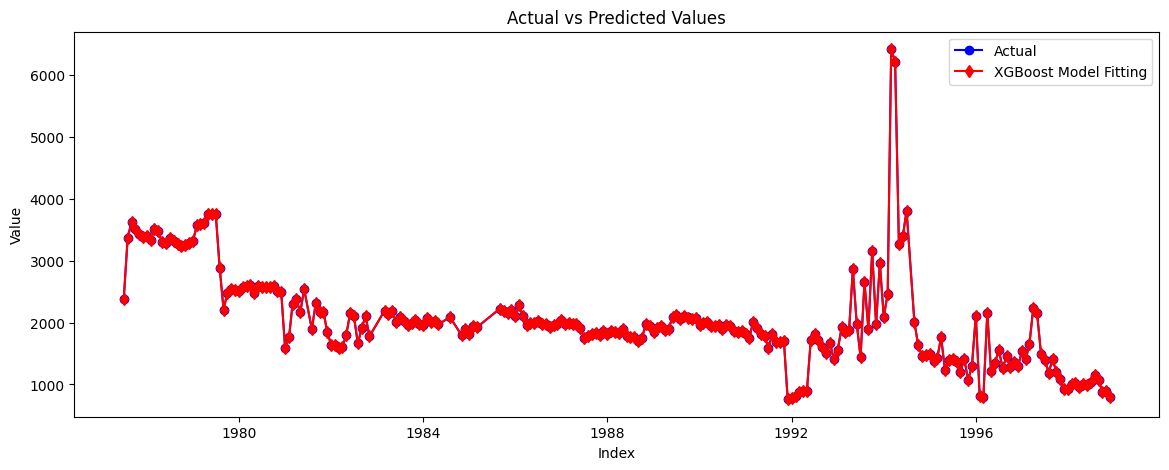

In [26]:
xgb_train_forecast = xgb_model_best.predict(X_train_windows)
plot_forecast(y_train_windows, xgb_train_forecast, ds_train_windows.flatten(), "XGBoost Model Fitting")

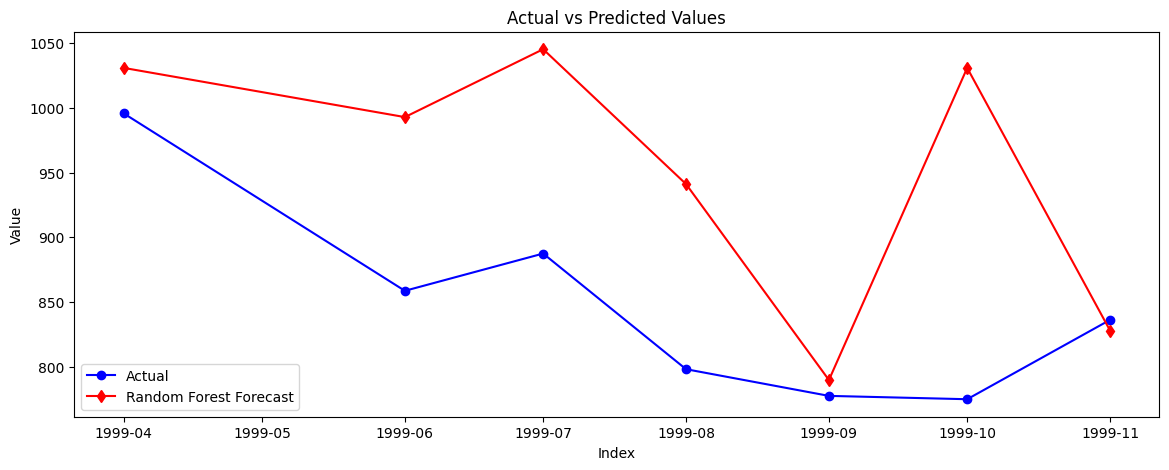

In [66]:
plot_forecast(y_test_windows, xgb_forecast, ds_test_windows.flatten())

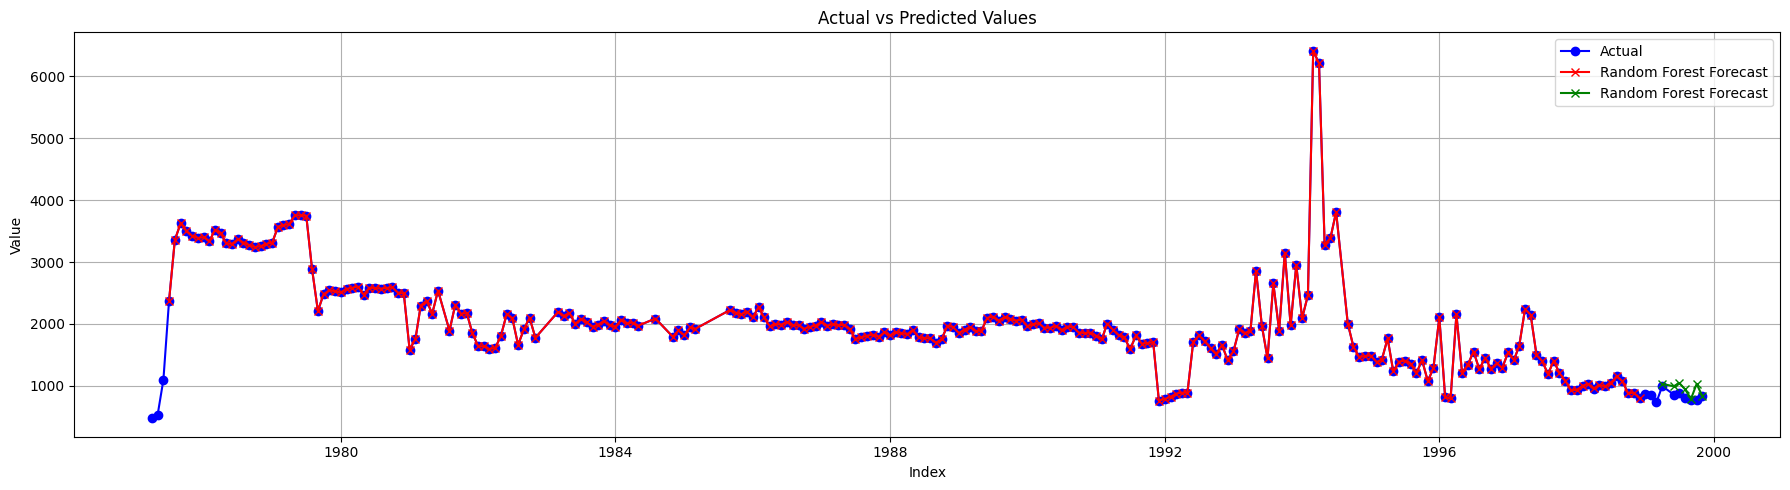

In [71]:
import matplotlib.pyplot as plt

#def plot_forecast(y_test, y_forecast, ds):
    # Plotting actual vs predicted values
plt.figure(figsize=(18, 5))
plt.plot(df_pdoil_clean['ds'], df_pdoil_clean['y'], color='b', label='Actual', marker='o')
plt.plot(ds_train_windows.flatten(), xgb_train_forecast, color='r', label='Random Forest Forecast', marker='x')
plt.plot(ds_test_windows.flatten(), xgb_forecast, color='g', label='Random Forest Forecast', marker='x')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
X_train[:5], y_train[:5]

(          ds
 0 1977-04-01
 1 1977-05-01
 2 1977-06-01
 3 1977-07-01
 4 1977-08-01,
 0     474.600000
 1     524.761905
 2    1096.793103
 3    2372.233010
 4    3357.987013
 Name: y, dtype: float64)

In [14]:
import pandas as pd

# Assuming X_train contains the latest timestamp
latest_timestamp = X_train['ds'].max()

# Generate future timestamps (e.g., forecasting for the next 5 days)
future_timestamps = pd.date_range(start=latest_timestamp, periods=5, freq='M')
future_timestamps

DatetimeIndex(['1998-12-31', '1999-01-31', '1999-02-28', '1999-03-31',
               '1999-04-30'],
              dtype='datetime64[ns]', freq='M')

In [15]:
window = X_train_windows[-1] 
window.reshape(1, -1).shape

(1, 3)

In [21]:
prediction = xgb_model_best.predict(window.reshape(1, -1))
prediction[0]

NameError: name 'xgb_model_best' is not defined

In [18]:
np.append(np.array([[1075.42266667,  882.30612903,  887.8943128 ]]).flatten()[1:], prediction).reshape(1, -1)

NameError: name 'prediction' is not defined

array([800.88165], dtype=float32)

In [124]:
X_test

,ds
247,1999-01-01
248,1999-02-01
249,1999-03-01
250,1999-04-01
252,1999-06-01
253,1999-07-01
254,1999-08-01
255,1999-09-01
256,1999-10-01
257,1999-11-01


In [130]:
latest_timestamp = X_test['ds'].iloc[-1]
latest_timestamp

Timestamp('1999-11-01 00:00:00')

In [131]:
pd.date_range(start=latest_timestamp, periods=12, freq='M')  # Your desired future timestamps

DatetimeIndex(['1999-11-30', '1999-12-31', '2000-01-31', '2000-02-29',
               '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30',
               '2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31'],
              dtype='datetime64[ns]', freq='M')

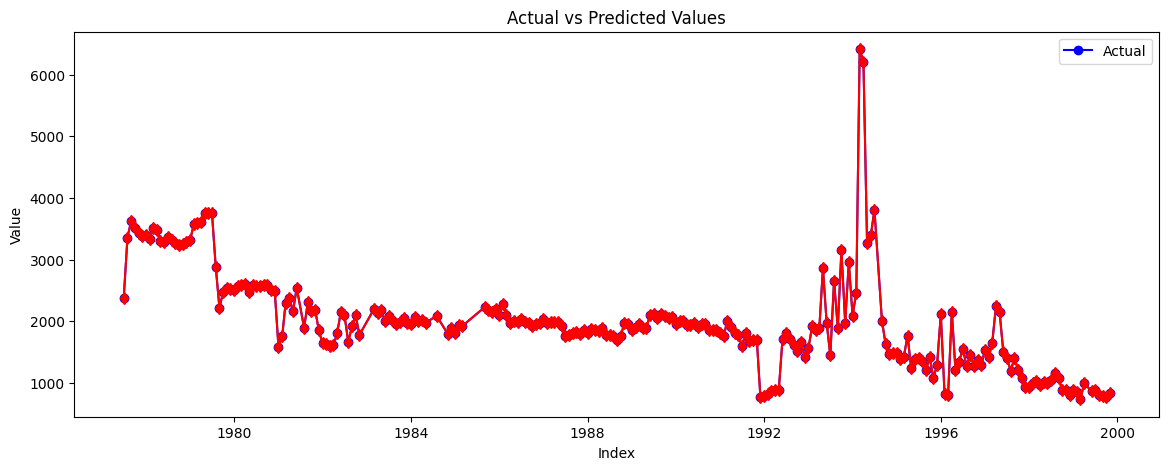

In [28]:
df_traintest = pd.concat((df_train, df_test)) # combined for full training
df_date = df_traintest['ds']

y_forecast = df_traintest['y']
X_forecast_windows, y_forecast_windows = create_windows(y_forecast.values)
_, ds_traintest = create_windows(df_date.values)


xgb_traintest_best = XGBRegressor(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=300
)

xgb_traintest_best.fit(X_forecast_windows, y_forecast_windows)

y_xgb_forecast = xgb_traintest_best.predict(X_forecast_windows)
#y_forecast_windows.shape, y_xgb_forecast.shape, ds_traintest.shape

plot_forecast(y_forecast_windows, y_xgb_forecast, ds_traintest)

In [29]:
# Initialize a list to store forecasted values
forecast = []

# Initialize the initial window for the XGBoost model
window = X_test_windows[-1].reshape(1, -1)  # Assuming window_size is defined

# Generate future timestamps for forecasting
PERIODS=24
latest_timestamp = X_test['ds'].iloc[-1]
future_timestamps = pd.date_range(start=latest_timestamp, periods=PERIODS, freq='M')  # Your desired future timestamps

# Iterate through future timestamps
for timestamp in future_timestamps:
    # Use the current window to predict the next value
    prediction = xgb_traintest_best.predict(window)  # Reshape the window as needed
    
    # Append the prediction to the forecast
    forecast.append(prediction[0])
    
    # Update the window by removing the oldest value and adding the latest prediction
    window = np.append(window.flatten()[1:], prediction).reshape(1, -1)

# Create a DataFrame with the forecasted values and their corresponding timestamps
forecast_df = pd.DataFrame({'ds': future_timestamps, 'yhat': forecast})

future_forcast = forecast_df['yhat']
future_ds = forecast_df['ds']

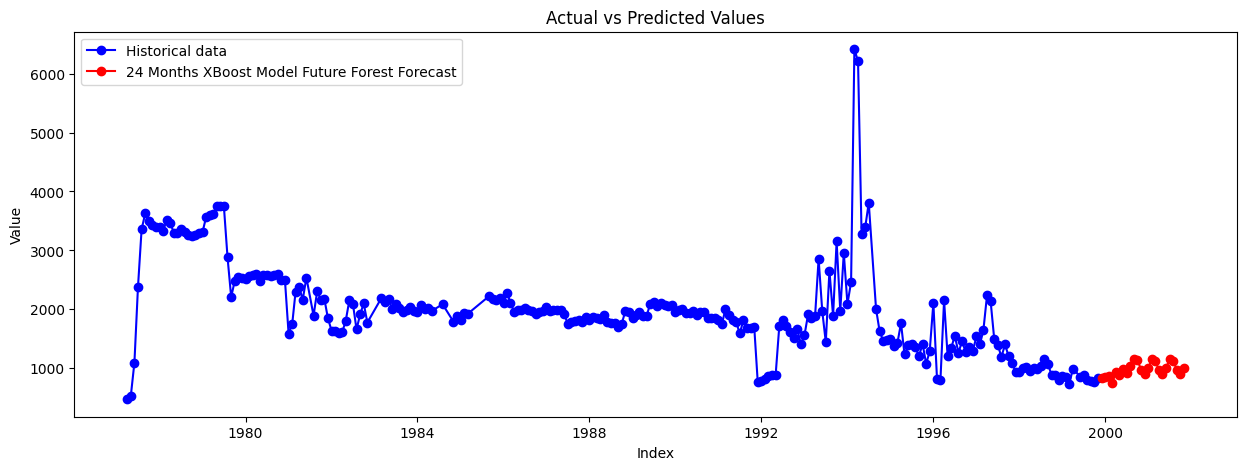

In [35]:
import matplotlib.pyplot as plt

#def plot_forecast(y_test, y_forecast, ds):
    # Plotting actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(df_pdoil_clean['ds'], df_pdoil_clean['y'], color='b', label='Historical data', marker='o')
#plt.plot(ds_train_windows.flatten(), xgb_train_forecast, color='r', label='Random Forest Forecast', marker='x')
plt.plot(future_ds, future_forcast, color='r', label=f'{PERIODS} Months XBoost Model Future Forest Forecast', marker='o')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
#plt.grid(True)
#plt.tight_layout()
plt.show()